Original code by Will Redman https://wredman4.wixsite.com/wtredman, adapted to python by Francisco Acosta

### Imports

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import matplotlib.pyplot as plt
import numpy as np
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

INFO: Using pytorch backend


### Functions

In [2]:
def create_reference_lattice(lx, ly, arena_dims):
    """Create hexagonal reference periodic lattice.

    Parameters
    ----------
    lx : float
        Horizonatal distance between grid cell fields
    ly : float
        Vertical distance between grid cell fields
    arena_dims : numpy.ndarray, shape=(2,)
        Dimensions of rectangular arena, [length, height]

    Returns
    -------
    ref_lattice : numpy.ndarray, shape=((ceil(dims[0]/lx)+1)*(ceil(dims[1]/ly)+1),2)
        Reference periodic lattice, specified by listing the x-y coordinates of each field

    """

    n_x = np.arange(-(arena_dims[0] / lx) // 2, (arena_dims[0] / lx) // 2 + 1)
    n_y = np.arange(-(arena_dims[1] / ly) // 2, (arena_dims[1] / ly) // 2 + 1)
    N_x, N_y = np.meshgrid(n_x, n_y)

    offset_x = np.tile([[0], [0.5]], np.shape(N_x))[: np.shape(N_x)[0], :]

    X = lx * (N_x + offset_x)
    Y = ly * N_y

    ref_lattice = np.hstack((np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1))))

    return ref_lattice

In [3]:
def generate_all_grids(grid_scale, arena_dims, n_cells, grid_orientation_mean, grid_orientation_std):
    """Create lattices for all grid cells within a module, with varying phase & orientation.

    Parameters
    ----------
    grid_scale : float
        Spacing between fields (lattice constant)
    dims : numpy.ndarray, shape=(2,)
        Dimensions of rectangular arena, [length, height]
    n_cells : int
        Number of grid cells in module
    grid_orientation_mean : float \in [0,360)
        Mean orientation angle of grid cell lattices, in degrees
    grid_orientation_std : float
        Standard deviation of orientation distribution (modeled as Gaussian), in degrees

    Returns
    -------
    grids : numpy.ndarray, shape=(num_cells, num_fields_per_cell = (ceil(dims[0]/lx)+1)*(ceil(dims[1]/ly)+1),2)
        All the grid cell lattices.
    """
    lx = grid_scale
    ly = grid_scale * np.sqrt(3) / 2

    ref_lattice = create_reference_lattice(lx, ly, arena_dims)

    grids = np.zeros((n_cells,) + np.shape(ref_lattice))

    for i in range(n_cells):
        angle_i = np.random.normal(grid_orientation_mean, grid_orientation_std) * (np.pi / 180)
        rot_i = np.array(
            [[np.cos(angle_i), -np.sin(angle_i)], [np.sin(angle_i), np.cos(angle_i)]]
        )
        phase_i = np.multiply([lx, ly], np.random.rand(2))
        lattice_i = np.matmul(rot_i, ref_lattice.T).T + phase_i

        lattice_i = np.where(abs(lattice_i) < arena_dims / 2, lattice_i, None)

        grids[i, :, :] = lattice_i

    return grids

In [4]:
def viz(grids, arena_dims):
    """Visualize the the firing lattices for all grid cells."""

    colormap = plt.get_cmap("hsv")
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_facecolor("darkblue")
    ax.set_xlim(-arena_dims[0] / 2 - 0.5, arena_dims[0] / 2 + 0.5)
    ax.set_ylim(-arena_dims[1] / 2 - 0.5, arena_dims[1] / 2 + 0.5)
    ax.set_title("Hexagonal grids")
    ax.set_xlabel("x-position")
    ax.set_ylabel("y-position")
    for lattice in grids:
        plt.scatter(lattice[:, 0], lattice[:, 1])

In [5]:
def create_rate_maps(grids, field_width, arena_dims, resolution):
    """Create 2D firing rate maps for all grid cells.

    Parameters
    ----------
    grids : numpy.ndarray, shape=(num_cells, num_fields_per_cell = (ceil(dims[0]/lx)+1)*(ceil(dims[1]/ly)+1),2)
         All the grid cell lattices.
    field_width : float
        width of firing field, expressed as variance of Gaussian
    arena_dims : numpy.ndarray, shape=(2,)
        Dimensions of rectangular arena, [length, height]
    resolution : int
        Spatial resolution of computed rate map

    Returns
    -------
    rate_maps : numpy.ndarray, shape=(num_cells, d,d)
        Discretized 2D firing field lattice for all grid cells

    """
    X = np.linspace(-arena_dims[0] / 2, arena_dims[0] / 2, resolution)
    Y = np.linspace(-arena_dims[1] / 2, arena_dims[1] / 2, resolution)
    rate_maps = np.zeros((len(grids), len(X), len(Y)))

    for cell_index in range(len(grids)):
        for x in range(len(X)):
            for y in range(len(Y)):
                for vertex in range(grids.shape[1]):
                    if not np.isnan(grids[cell_index, vertex]).any():
                        rate_maps[cell_index, x, y] += np.exp(
                            -(
                                (grids[cell_index, vertex, 0] - X[x]) ** 2
                                + (grids[cell_index, vertex, 1] - Y[y]) ** 2
                            )
                            / (2 * field_width)
                        )

    return rate_maps

### Visualize all grids

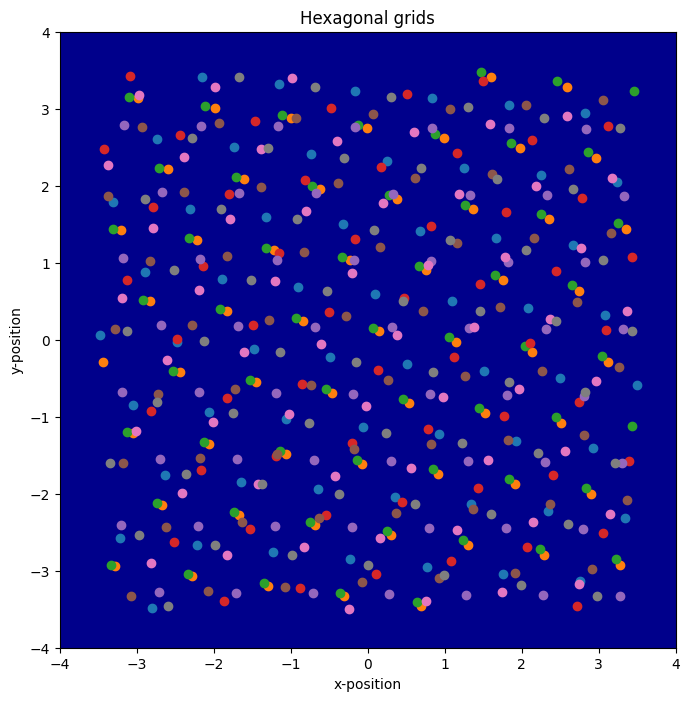

In [10]:
grid_scale = 1
arena_dims = np.array([7, 7])
n_cells = 8
grid_orientation_mean = 0
grid_orientation_std = 6

grids = generate_all_grids(grid_scale, arena_dims, n_cells, grid_orientation_mean, grid_orientation_std)
viz(grids, arena_dims)

### Plot rate maps

In [49]:
rate_maps = create_rate_maps(grids, field_width=0.05, arena_dims=arena_dims, resolution=40)

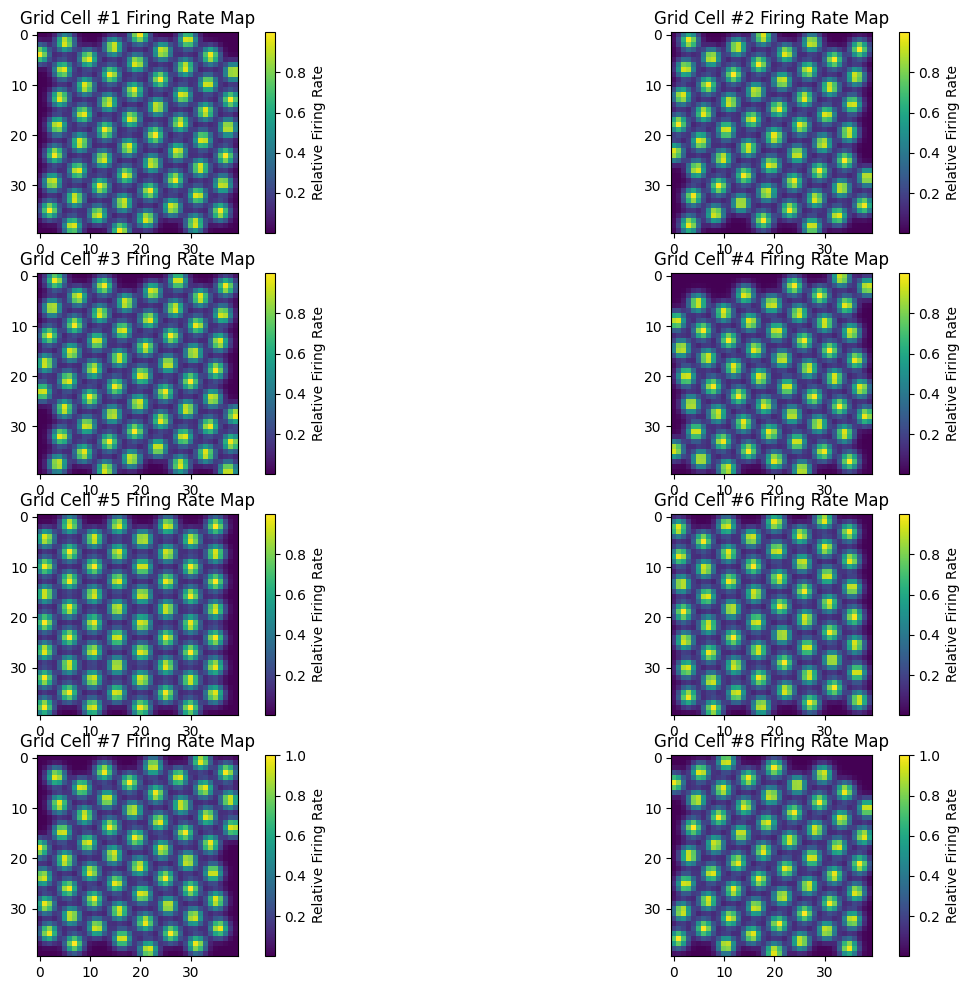

In [50]:
fig = plt.figure(figsize=(15,12))
for cell_index in range(n_cells):
    ax = fig.add_subplot(int(np.ceil(n_cells/2)),2,cell_index+1)
    img = ax.imshow(rate_maps[cell_index])
    plt.colorbar(img,label = "Relative Firing Rate")
    ax.set_title("Grid Cell #" + str(cell_index + 1) + " Firing Rate Map")

#plt.imshow(r[0]);

In [34]:
def zig_zag_flatten(matrix):
    num_rows, num_columns = matrix.shape
    
    flattened = np.zeros(num_rows*num_columns)
    
    for row_index in range(num_rows):
        if row_index % 2 == 0:
            flattened[row_index*num_columns:(row_index+1)*num_columns] = matrix[row_index]
        else:
            flattened[row_index*num_columns:(row_index+1)*num_columns] = matrix[row_index,::-1]
    return flattened

In [40]:
def get_neural_activity(rate_maps):
    
    num_points = rate_maps.shape[1]*rate_maps.shape[2]
    
    num_cells = rate_maps.shape[0]
    
    neural_activity = np.zeros((num_points,num_cells))
    
    for cell_index in range(num_cells):
        neural_activity[:,cell_index] = zig_zag_flatten(rate_maps[cell_index])
    
    return neural_activity

In [60]:
neural_activity = get_neural_activity(rate_maps)